# Calling Python and C from Julia

1. Python -- the PyCall package
2. C (and Fortran) Libraries -- the native Julia functions

## Calling Python

We can use the `PyCall` package to call Python code from Julia.

In [1]:
using PyCall

In [2]:
# The following makes it so that print statements in python will appear in this notebook
# This is not necessary when using PyCall in a terminal based Julia instance
pyimport("sys")."stdout" = PyTextIO(stdout)
pyimport("sys")."stderr" = PyTextIO(stderr);

We can execute arbitrary Python code with the special Julia strings `py"..."` and `py"""..."""`.

In [3]:
py"""
import math
class Point:
    def __init__(self, x,y):
        self.x = x
        self.y = y
    def distance(self, p):
        return math.sqrt((self.x - p.x)**2 + (self.y - p.y)**2)
"""

p = py"Point(1.0, 2.0)"

PyObject <__main__.Point object at 0x7fa3d66bd340>

## Calling Python

We can even use Julia's string interpolation to give values to the Python code:

In [4]:
x = rand()
q = py"Point($(x), $rand())"

PyObject <__main__.Point object at 0x7fa3d66bdb80>

Attributes are directly accessible through the standard dot syntax:

In [5]:
@show p.x
@show p.distance(q);

p.x = 1.0
p.distance(q) = 1.7581695820873517


## Calling Python

But say we have a module in Python that we want to call from Julia.  We can do that too (otherwise this wouldn't be much use would it?). The `pyimport` function returns an object that gives us access to that modules functions:

In [6]:
np = pyimport("numpy")
A = rand(3,3)
b = rand(3)
x = np.linalg.solve(A, b)
@show maximum(abs.(A * x - b));

maximum(abs.(A * x - b)) = 1.1102230246251565e-16


## Calling Python

In the previous slide `A` and `b` are created by Julia while `x` is created by Python but we are using them interchangeably. We can do this because PyCall handles most type conversions automatically.

In [7]:
for x in [5.0, 2, ["a", "b"], Dict("a"=>rand(), "b"=>rand()), A]
    @show typeof(x)
    py"""print(type($x))"""
end

typeof(x) = Float64
<class 'float'>
typeof(x) = Int64
<class 'int'>
typeof(x) = Vector{String}
<class 'list'>
typeof(x) = Dict{String, Float64}
<class 'dict'>
typeof(x) = Matrix{Float64}
<class 'numpy.ndarray'>


Note that the matrix is converted to a numpy array if numpy is installed.

## Calling Python

The same is true going from Python to Julia.

In [8]:
py"""
objs = [{'a':1,'b':2}, [1, 'a', 3.0], 2.0+3j]
for k in range(len(objs)):
    $println($typeof(objs[k]))
    print(type(objs[k]))
"""

Dict{Any, Any}
<class 'dict'>
Vector{Any}
<class 'list'>
ComplexF64
<class 'complex'>


## Calling Python

We do need to be a little careful with some of Julia's less common types especially if we give it to python and bring it back:

In [9]:
a = Int32(5)
@show typeof(a)
@show typeof(py"$a");

typeof(a) = Int32
typeof(py"$a") = Int64


In these cases, we may want to handle the conversion ourselves. One option is getting the raw `PyObject` back by using the `py"..."o` syntax and then calling an appropriate `convert` function:

In [10]:
@show typeof(a)
@show typeof(py"$a"o)
@show typeof(convert(Int32, py"$a"o));

typeof(a) = Int32
typeof(py"$a"o) = PyObject
typeof(convert(Int32, py"$a"o)) = Int32


## Calling Python

Another way of handling (or preventing) type conversions is to use the `pycall` function. 

In [11]:
pycall(np.random.normal, PyObject, size=3)

PyObject array([ 1.27173788, -0.55905635, -1.81371862])

Here we specified to leave the object as a raw PyObject (i.e. no type conversion at all)

We can also give it a Julia type to convert to

In [12]:
pycall(np.random.normal, Vector{ComplexF32}, size=3)

3-element Vector{ComplexF32}:
 0.82824904f0 + 0.0f0im
 -1.8152742f0 + 0.0f0im
  0.6555549f0 + 0.0f0im

Here we forced the type conversion to complex numbers with 32-bit precision for the real and imaginary parts.

## Calling Python

But what if we need to call a Python function that requires a callback? Not a problem. PyCall will automatically convert Julia functions to Python callable objects!

In [13]:
si = pyimport("scipy.integrate")
tk = 0.0:1e-2:10.0
function my_ode(t::Float64, y::Vector{Float64})::Vector{Float64}
    dy = zeros(length(y))
    dy[1] = 5.0*y[1] - 5.0*y[1]*y[2]
    dy[2] = y[1]*y[2] - y[2]
    return dy
end
soln = si.solve_ivp(my_ode, (0.0, 10.0), [5.0, 1.0], t_eval=tk);

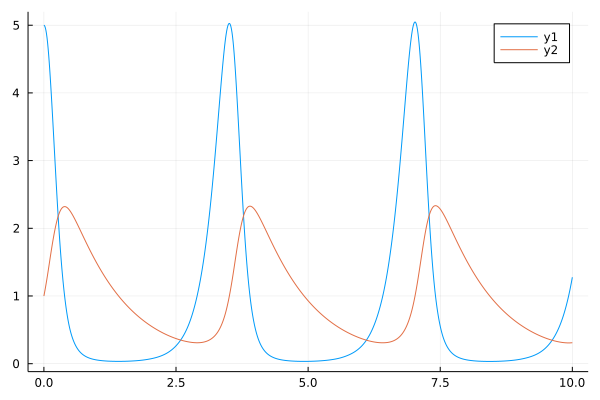

In [14]:
using Plots
plot(soln["t"], soln["y"]')

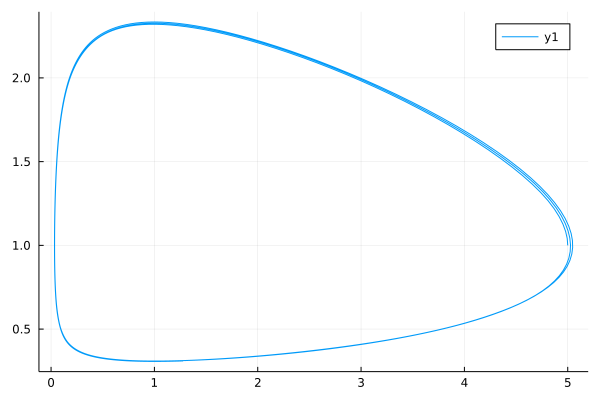

In [15]:
plot(soln["y"][1,:], soln["y"][2,:])

## Calling Python

For more details, see the [PyCall github repo](https://github.com/JuliaPy/PyCall.jl.git).

## Calling C/Fortran Library

Here we will discuss how to call a C library function from within Julia.

Calling a Fortran library function is the same except that Fortran compilers "mangle" the function names. This means that they are not precisely the same names as in the source code and you need to know what compiler was used to compile the Fortran library so you can determine the mangling scheme.

Note that the library we are calling must be compiled as a shared library.

## Calling C Library

As an example we will use the "silly" library that was written just for this.

Here are the functions available in the silly library:
```C
void fill_zeros(double *to_fill, int size);
void fill_value(double *to_fill, int size, double value);
void fill_cb(double *to_fill, int size, double (*func)(int));
```

## Calling C Library

To call one of these functions, we will use the builtin Julia function `ccall`:

In [16]:
N = 4
my_vector = Vector{Float64}(undef, N)
@show my_vector
ccall((:fill_zeros,"fake-lib/libsilly"), # function and library
    Cvoid, # return type
    (Ref{Float64}, Cint), # argument types
    my_vector, N # arguments
)
@show my_vector
ccall((:fill_value,"fake-lib/libsilly"),
    Cvoid,
    (Ref{Float64}, Cint, Cdouble),
    my_vector, N, pi
)
@show my_vector;

my_vector = [2.257468188e-314, 0.0, 2.257517705e-314, 2.257468188e-314]
my_vector = [0.0, 0.0, 0.0, 0.0]
my_vector = [3.141592653589793, 3.141592653589793, 3.141592653589793, 3.141592653589793]


## Calling C Library

What if we want to use a function that requires a callback (so one of its arguments is a function pointer)? We can create a pointer to a Julia function with the `@cfunction` macro.

In [17]:
function my_filler(index::Int)::Float64
    return index / 10.0
end
cfunc = @cfunction(my_filler, Float64, (Int,))

Ptr{Nothing} @0x000000017ee10ec0

Now we call the C function with `ccall` as before. The type of the function pointer is `Ptr{Cvoid}`.

In [18]:
ccall((:fill_cb, "fake-lib/libsilly"),
    Cvoid,
    (Ref{Float64}, Cint, Ptr{Cvoid}),
    my_vector, N, cfunc)
@show my_vector;

my_vector = [0.0, 0.1, 0.2, 0.3]


## Calling C Library

For more details, see the [Calling C and Fortran Code](https://docs.julialang.org/en/v1/manual/calling-c-and-fortran-code/) section of the Julia documentation. (If the link does not work, just google "julia call c library".)

A more complex example is provided by [Ipopt.jl](https://github.com/jump-dev/Ipopt.jl). You may also wish to look at the Ipopt library C API. The easiest way to do this is actually to just look at the header file at src/Interfaces/IpStdCInterface.h which is viewable at the [Ipopt github repo](https://github.com/coin-or/Ipopt).

## Other Interfaces

Interested in calling a function/library written in something other than Python, C or Fortran? Checkout the [Julia Interop](https://github.com/JuliaInterop) group on GitHub. Interfaces already exist for C++, MATLAB, Mathematica and R to name a few.